# SNP Cross Disease Analysis

Perform analysis on SNPs linked with specific diseases and produce results and plots. Make sure there is a subfolder named "plots" and subfolders within "plots" named "boxplots", "violinplots", and "scatterplots" to save plots to. (Alternatively, rename where the plots are saved within the code.)

# Disease Analysis

Specific libraries are imported.

In [1]:
import csv
import numpy as np
import collections as col
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import ks_2samp

The lists of diseases and information relevant to files containing SNP effect size for these diseases such as file name, indices in files that contain SNP ID and effect size, and delimiters for the file type are initialized. The 11 specific diseases/traits/disorders analyzed are Alzheimer's, Parkinson's, Schizophrenia, Autism, Depression, Type 2 Diabetes, Body Mass Index, Obesity, Asthma, Smoking, and LDL Cholesterol Levels. The summary statistics for SNP effect size for each disease files are included and are all obtained from links on http://ldsc.broadinstitute.org/gwashare/. For each disease, the effect size may use Beta, which is centered around 0, or Odds Ratio, which is centered around 1.

Specifically, the summary statistics files for each disease came from the following links:

Alzheimer's: http://web.pasteur-lille.fr/en/recherche/u744/igap/igap_download.php

Parkinson's: https://www.ncbi.nlm.nih.gov/projects/SNP/gViewer/gView.cgi?aid=2868

Schizophrenia, Autism, Smoking: https://www.med.unc.edu/pgc/results-and-downloads

Depression: https://www.thessgac.org/data

Type 2 Diabetes: http://diagram-consortium.org/downloads.html

Body Mass Index, Obesity: http://portals.broadinstitute.org/collaboration/giant/index.php/GIANT_consortium_data_files

Asthma: http://www.cng.fr/gabriel/results.html

LDL Cholesterol: http://csg.sph.umich.edu//abecasis/public/lipids2013/

In [2]:
# List of diseases
diseases = ["Alzheimer", "Parkinson", "Schizophrenia", "Autism", "Depress", "Type 2 Diabetes", "Body Mass Index", "Obesity", "Asthma", "Smok", "LDL"]
disease_names = ["Alzheimer's", "Parkinson's", "Schizophrenia", "Autism", "Depression", "Type 2 Diabetes", "Body Mass Index", "Obesity", "Asthma", "Smoking", "LDL Cholesterol"]

numdiseases = len(diseases)

# List of disease summary statistics file names
diseasefiles = ["alzheimerssumstats.txt", "parkinsonssumstats.txt", "schizophreniasumstats.txt", "autismsumstats.txt", "depressionsumstats3.txt", "type2diabetessumstats.txt", "bmisumstats.txt", "obesitysumstats.txt", "asthmasumstats.txt", "smokingsumstats.tbl", "ldlsumstats.txt"]
# diseasefiles = ["alzheimerssumstats.filtered.txt", "parkinsonssumstats.filtered.txt", "schizophreniasumstats.filtered.txt", "autismsumstats.filtered.txt", "depressionsumstats3.filtered.txt", "type2diabetessumstats.filtered.txt", "bmisumstats.filtered.txt", "obesitysumstats.filtered.txt", "asthmasumstats.filtered.txt", "smokingsumstats.filtered.tbl", "ldlsumstats.filtered.txt"]

# List of corresponding indices for snpids and effect sizes for each disease file
fileindices = [(2, 5), (0, 13), (0, 5), (0, 5), (0, 6), (0, 6), (0, 7), (0, 4), (1, 7), (1, 8), (2, 5)]

# List of corresponding file delimiters
filedelimiters = ["\t", "\t", "\t", "\t", "\t", "\t", "\t", " ", "\t", "\t", "\t"]
# filedelimiters = [" "]*11

Additional data structures to store SNPs linked with each disease, SNP effect sizes for each disease, and whether or not there is a known effect size for a SNP for a specific disease are initialized.

In [3]:
# Dictionary of sets of Disease-related SNPs
snps = col.defaultdict(set)

# Dictionary of dicts from SNP to Beta for each disease
allsnpbetas = col.defaultdict(dict)

# Dictionary of disease to dict that tells whether SNP has known effect size from disease files or not
snpsindict = col.defaultdict(lambda: col.defaultdict(lambda: "no"))

# Dictionary of SNP to information about SNP from associations file
snpsinfo = {}

# List of sets of disease-related SNPs for each disease
diseasesnps = []

# List of sets of disease-related SNP betas for the same disease
diseasesnpbetas = []

# Lists of indicies of diseases summary statistics files that use beta vs odds ratio for effect size
betainds = [0, 4, 6, 7, 9, 10]
oddsinds = [1, 2, 3, 5, 8]

The filtered list of associations from SNAP is loaded and SNPs are read and categorized by disease/trait. The number of SNPs linked with each disease is printed.

In [4]:
# Read filtered SNPs and stores SNPs related to the specific diseases
with open("../SNP-Filtering-and-Analysis/out4.filterclosest.0.5filtered.tsv") as new:
# with open("../SNP-Filtering-and-Analysis/out3.0.5.filtered") as new:
# with open("snapfiltered.associations.new2.tsv") as new:
# with open("associations.known.tsv") as new:
    for line in csv.reader(new, delimiter="\t"):
        snpid = line[1]
        pheno = line[2]
        for disease in diseases:
            if disease.upper() in pheno.upper():
                snps[disease].add(snpid)
                paper = line[0]
                pvalue = line[4]
                snpsinfo[snpid] = (snpid, pheno, paper, pvalue)
                break

snps = {key: list(values) for key, values in snps.items()} # turns dict of sets into dict of lists
numsnps = [len(snps[disease]) for disease in diseases] # list of number of SNPs linked with each disease

for i in range(numdiseases):
    print "Number of " + diseases[i] + " SNPs:", numsnps[i]

Number of Alzheimer SNPs: 55
Number of Parkinson SNPs: 43
Number of Schizophrenia SNPs: 11
Number of Autism SNPs: 19
Number of Depress SNPs: 17
Number of Type 2 Diabetes SNPs: 17
Number of Body Mass Index SNPs: 40
Number of Obesity SNPs: 14
Number of Asthma SNPs: 32
Number of Smok SNPs: 6
Number of LDL SNPs: 16


All of the files that contain SNP effect size for each disease are read and the effect sizes are stored.

In [5]:
# Function to tell if input string is float or not
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

# Read disease files
for i in range(numdiseases):
    disease = diseases[i]
    file = diseasefiles[i]
    snpindex = fileindices[i][0]
    betaindex = fileindices[i][1]
    delim = filedelimiters[i]
    print i, disease, file
    with open(file) as new:
        for line in csv.reader(new, delimiter=delim):
            snpid = line[snpindex]
            if not is_number(line[betaindex]):
                continue
            beta = float(line[betaindex])
            allsnpbetas[disease][snpid] = beta
            snpsindict[disease][snpid] = "yes"

0 Alzheimer alzheimerssumstats.txt
1 Parkinson parkinsonssumstats.txt
2 Schizophrenia schizophreniasumstats.txt
3 Autism autismsumstats.txt
4 Depress depressionsumstats3.txt
5 Type 2 Diabetes type2diabetessumstats.txt
6 Body Mass Index bmisumstats.txt
7 Obesity obesitysumstats.txt
8 Asthma asthmasumstats.txt
9 Smok smokingsumstats.tbl
10 LDL ldlsumstats.txt


The cross disease analysis is then performed. For each disease 1's set of linked SNPs, for each disease 2, the average effect size of disease 1 linked SNPs is calculated for disease 2 (which leads to 11 average effect sizes for disease 1 SNPs, one for each disease 2). Then a number of random samples of SNPs (1000 in this case) of the same number of disease 1 SNPs for which there was a known effect size for disease 2 are chosen and their average effect sizes are calculated. Using this permutation test, we can determine whether or not the effect size for disease 1 SNPs with respect to disease 2 is significant or not by calculating a simple p-value of (total samples - # random samples where the effect size for the disease 1 sample > effect size for random sample) / (total samples). The number of disease 1 SNPs with known effect size for disease 2, average effect sizes, p-values, and -log(p-values) are stored in matrices. A p-value using the normal approximation is also calculated.

Additionally, for analyses of disease 1 SNPs with the same disease (when disease 1 = disease 2), scatterplots of the mean of the effect sizes of the sample of disease 1 SNPs are plotted along with the means of the 1000 random samples of SNPs for that disease.

In [6]:
# Create list of cross disease matrices for number of disease1 SNPs with known effect size for disease2, average effect sizes, p-values using perumtation test, log p-values, and normal approx. p-values
crossdiseases = [np.zeros((numdiseases, numdiseases)) for i in range(5)]

totalsamples = 1000

# Information used for later plots
allavgsamplebetas = [] # list of lists that contain the mean effect size for the random samples for each disease 
allavgbetas = [] # list mean effect size for the disease linked SNPs with the same disease for each disease

for i in range(numdiseases):
    disease1 = diseases[i]
    print i, disease1
    snplist = snps[disease1] # disease1 linked SNPs
    for j in range(numdiseases):
        disease2 = diseases[j]
        snpbetas = []
        dsnplist = []
        for snp in snplist:
            if snpsindict[disease2][snp] == "no": # if no effect size for disease2 for a disease1 linked SNP, skip
                continue
            snpbetas.append(allsnpbetas[disease2][snp]) # add effect size of SNP to list
            dsnplist.append(snp) # add SNP name to list

        if i == j: # if disease linked SNPs analyzed with same disease, get information
            diseasesnps.append(dsnplist)
            diseasesnpbetas.append(snpbetas)
        
        # Number of disease1 linked SNPs that have known effect size for disease2 and their average effect sizes
        numsnpbetas = len(snpbetas)
        avgbeta = np.mean(snpbetas)
        
        #****CHANGE HERE FOR ALTERNATIVE METRICS****
        #avgbeta = np.median(snpbetas)
        #avgbeta = np.percentile(snpbetas, 70)
        #avgbeta = np.percentile(snpbetas, 80)
        
        if i == 0 and j == 10:
            ldl_snps1 = dsnplist, snpbetas
        
        if i == 10 and j == 0:
            ldl_snps2 = dsnplist, snpbetas

        # Create random samples of all known SNPs with effect size for disease2
        allsnps = allsnpbetas[disease2].keys()
        avgsamplebetas = []
        for k in range(totalsamples):
            randsample = random.sample(allsnps, numsnpbetas)
            avgsamplebeta = np.mean([allsnpbetas[disease2][snp] for snp in randsample])
            
            #****CHANGE HERE FOR ALTERNATIVE METRICS****
            #avgsamplebeta = np.median([allsnpbetas[disease2][snp] for snp in randsample])
            #avgsamplebeta = np.percentile([allsnpbetas[disease2][snp] for snp in randsample], 70)
            #avgsamplebeta = np.percentile([allsnpbetas[disease2][snp] for snp in randsample], 80)
            avgsamplebetas.append(avgsamplebeta)

        # Plot Scatter if disease-linked snps with same disease, abs(beta) if using beta and abs(log(OR)) if using odds ratio
        if i == j:
            allavgsamplebetas.append(avgsamplebetas)
            allavgbetas.append(avgbeta)
            plt.clf()
            if i in betainds:
                plt.plot(range(1, totalsamples + 1), np.absolute(avgsamplebetas), 'bo', markersize=5, label="Random SNP Samples")
                plt.plot((0, totalsamples + 1), (np.absolute(avgbeta), np.absolute(avgbeta)), 'r-', label=disease1 + " SNPs")
            else:
                plt.plot(range(1, totalsamples + 1), np.absolute(np.log10(avgsamplebetas)), 'bo', markersize=5, label="Random SNP Samples")
                plt.plot((0, totalsamples + 1), (np.absolute(np.log10(avgbeta)), np.absolute(np.log10(avgbeta))), 'r-', label=disease1 + " SNPs")
            plt.title("Average Effect Size of "+ disease1 + " SNPs vs " + str(totalsamples) + " Random Samples", fontsize=10)
            
            #****CHANGE HERE FOR ALTERNATIVE METRICS****
            #plt.title("Median Effect Size of "+ disease1 + " SNPs vs " + str(totalsamples) + " Random Samples", fontsize=10)
            #plt.title("70th Percentile Effect Size of "+ disease1 + " SNPs vs " + str(totalsamples) + " Random Samples", fontsize=10)
            #plt.title("80th Percentile Effect Size of "+ disease1 + " SNPs vs " + str(totalsamples) + " Random Samples", fontsize=10)
            
            plt.xlabel("Sample")
            if i in betainds:
                plt.ylabel("|Average Effect Size| (Beta)")
                
                #****CHANGE HERE FOR ALTERNATIVE METRICS****
                #plt.ylabel("Median Effect Size (Beta)")
                #plt.ylabel("70th Percentile Effect Size (Beta)")
                #plt.ylabel("80th Percentile Effect Size (Beta)")
            else:
                plt.ylabel("log|Average Effect Size| (Odds Ratio)")
                
                #****CHANGE HERE FOR ALTERNATIVE METRICS****
                #plt.ylabel("Median Effect Size (Odds Ratio)")
                #plt.ylabel("70th Percentile Effect Size (Odds Ratio)")
                #plt.ylabel("80th Percentile Effect Size (Odds Ratio)")
            plt.xlim(0, totalsamples + 1)
            plt.legend(loc="upper right", handlelength=1, handleheight=1, fontsize=5)
            plt.savefig("plots/scatterplots/" + disease1 + "scatter.pdf")
            
            #****CHANGE HERE FOR ALTERNATIVE METRICS****
            #plt.savefig("plots2/scatterplots/median/" + disease1 + "scatter.pdf")
            #plt.savefig("plots2/scatterplots/70/" + disease1 + "scatter.pdf")
            #plt.savefig("plots2/scatterplots/80/" + disease1 + "scatter.pdf")

        # Get p-value of disease1 SNPs being linked to disease2

        # Get p-val for normal dist assumption
        samplemean = np.mean(avgsamplebetas)
        sampledev = np.std(avgsamplebetas)
        zscore = (avgbeta - samplemean) / sampledev
        npval = norm.sf(zscore)

        # P-val for permutation test using the random samples
        numgreaterthan = len([beta for beta in avgsamplebetas if avgbeta > beta])
        pval = float(totalsamples + 1 - numgreaterthan) / (totalsamples + 1)

        # Store cross disease analysis p-values and other information
        crossdiseases[0][i][j] = numsnpbetas
        crossdiseases[1][i][j] = avgbeta
        crossdiseases[2][i][j] = pval
        crossdiseases[3][i][j] = -np.log10(pval)
        crossdiseases[4][i][j] = npval

0 Alzheimer
1 Parkinson
2 Schizophrenia
3 Autism
4 Depress
5 Type 2 Diabetes
6 Body Mass Index
7 Obesity
8 Asthma
9 Smok
10 LDL


Let's save the pre-computed values.

In [26]:
import pickle
pickle.dump([allavgsamplebetas, allavgbetas, diseasesnps, diseasesnpbetas, crossdiseases], open('stats.pkl', 'wb'))

Here, we reload them.

In [75]:
import pickle
allavgsamplebetas, allavgbetas, diseasesnps, diseasesnpbetas, crossdiseases = pickle.load(open('stats.pkl', 'rb'))
totalsamples = 1000

Below, we are going to plot the distribution of effect sizes as histograms.

In [7]:
# plt.style.use('ggplot')
for i in range(numdiseases):
    print i, diseases[i]
    disease1 = diseases[i]
    plt.clf()    
    if i in betainds:
        plt.hist(np.absolute(allavgsamplebetas[i]), label="Random SNP Samples", bins=50)
        plt.axvline(np.absolute(allavgbetas[i]), color='b', label='GWASkb SNPs')
        plt.xlabel("Average Effect Size (|Beta|)")
    else:
        plt.hist(np.absolute(np.log10(allavgsamplebetas[i])), label="Random SNP Samples", bins=50)
        plt.axvline(np.absolute(np.log10(allavgbetas[i])), color='b', label='GWASkb SNPs')      
        plt.xlabel("Average Effect Size (|log OR|)")       
    plt.ylabel("Counts")
    plt.title("Average Effect Size of "+ disease1 + " SNPs vs " + str(totalsamples) + " Random Samples", fontsize=12)
    # plt.plot((0, totalsamples + 1), (np.absolute(avgbeta), np.absolute(avgbeta)), 'r-', label=disease1 + " SNPs")
    
#     plt.xlim(0, totalsamples + 1)
    plt.legend(loc="upper right", fontsize=8)
    plt.savefig("plots/histograms/" + disease1 + ".hist.pdf")

0 Alzheimer
1 Parkinson
2 Schizophrenia
3 Autism
4 Depress
5 Type 2 Diabetes
6 Body Mass Index
7 Obesity
8 Asthma
9 Smok
10 LDL


Furthermore, the Kolmogorov-Smirnov p-values between the disease 1 linked SNPs and the whole distribution of all SNPs with effect sizes for disease 1 are computed which basically tells how likely it is that the two samples come from the same distribution. Lists of all SNPs that have a known effect size for each disease are also found and stored for later plots.

In [8]:
# Lists of all SNPs for each disease and their averages
alldiseasesnpbetas = []
alldiseasesnpsavg = []

ksstats = [] # list of KS pvals of each disease's linked SNPs with whole distribution of SNPs with effect size for that disease

# Only want to plot values that are within two standard deviations to have clear ranges on plots and not saturate axes
for i in range(numdiseases):
    diseasebetas = allsnpbetas[diseases[i]].values()
    diseaseavg = np.mean(diseasebetas)
    diseasestd = np.std(diseasebetas)
    ndiseasebetas = [beta for beta in diseasebetas if beta <= diseaseavg + (2 * diseasestd) and beta >= diseaseavg - (2 * diseasestd)]
    ndiseaseavg = np.mean(ndiseasebetas)
    alldiseasesnpbetas.append(ndiseasebetas)
    alldiseasesnpsavg.append(ndiseaseavg)
    ksstat, kspval = ks_2samp(diseasesnpbetas[i], diseasebetas)
    ksstats.append(kspval)

All of this information regarding number of each disesase linked SNPs that have effect size for all other diseases, cross disease p-values, KS p-value, and which diseases each set of disease-linked SNPs are significant in are all printed to an output file.

In [9]:
# Write results to file
results = open("crossdiseases.txt", "w")

results.write("Number of Row Disease SNPs with Known Effect Size for Column Disease SNPs, Average Effect Size of Row Disease SNPs for Column Disease, P-Value for Row Disease Snps Effect Size for Column Disease Matrices\n\n")

for i in range(numdiseases):
    results.write("Number of " + diseases[i] + " SNPs: " + str(numsnps[i]) + "\n")
results.write("\n")

for disease in diseases:
    results.write(disease + "\t")
results.write("\n\n")

numsnpbetasmatrix = crossdiseases[0]
results.write("Number of Row Disease SNPs with Known Effect Size for Column Disease\n")
for i in range(numdiseases):
    for j in range(numdiseases):
        results.write(str(numsnpbetasmatrix[i][j]) + "\t")
    results.write("\n")
results.write("\n")

avgbetamatrix = crossdiseases[1]
results.write("Average Effect Size of Row Disease SNPs for Column Disease\n")
for i in range(numdiseases):
    for j in range(numdiseases):
        results.write(str(avgbetamatrix[i][j]) + "\t")
    results.write("\n")
results.write("\n")

npvalmatrix = crossdiseases[4]
results.write("P-Value of Row Disease SNPs for Column Disease Using Normal Approximation\n")
for i in range(numdiseases):
    for j in range(numdiseases):
        results.write(str(npvalmatrix[i][j]) + "\t")
    results.write("\n")
results.write("\n")

pvalmatrix = crossdiseases[2]
results.write("P-Value of Row Disease SNPs for Column Disease Using Permutation Test\n")
for i in range(numdiseases):
    for j in range(numdiseases):
        results.write(str(pvalmatrix[i][j]) + "\t")
    results.write("\n")
results.write("\n")

logmatrix = crossdiseases[3]
results.write("-log of P-Value of Row Disease SNPs for Column Disease Using Permutation Test\n")
for i in range(numdiseases):
    for j in range(numdiseases):
        results.write(str(logmatrix[i][j]) + "\t")
    results.write("\n")
results.write("\n")

results.write("KS P-Value of Disease SNPs with All SNPs with Effect Size for that Disease\n")
for i in range(numdiseases):
    results.write(diseases[i] + ": " + str(ksstats[i]) + "\n")
results.write("\n")

significancethresh = 0.05

for i in range(numdiseases):
    results.write("Other Diseases where " + diseases[i] + " SNPs have Significant Normal Approximation P-Values: ")
    for j in range(numdiseases):
        if npvalmatrix[i][j] <= significancethresh:
            results.write(diseases[j] + ": " + str(npvalmatrix[i][j]) + ", ")
    results.write("\n")
results.write("\n")

for i in range(numdiseases):
    results.write("Other Diseases where " + diseases[i] + " SNPs have Significant Permutation Test P-Values: ")
    for j in range(numdiseases):
        if pvalmatrix[i][j] <= significancethresh:
            results.write(diseases[j] + ": " + str(pvalmatrix[i][j]) + ", ")
    results.write("\n")
results.write("\n")

results.close()

SNPs linked to each disease are also printed to an output file.

In [10]:
diseasesnpfile = open("diseasesnps.txt", "w")

diseasesnpfile.write("SNP\tPheno\tPaper\tP-Value\n")
for i in range(numdiseases):
    diseasesnpfile.write(diseases[i] + " related SNPs:\n")
    for snp in diseasesnps[i]:
        snpinfo = snpsinfo[snp]
        diseasesnpfile.write(snpinfo[0] + "\t" + snpinfo[1] + "\t" + snpinfo[2] + "\t" + snpinfo[3] + "\n")
    diseasesnpfile.write("\n")

diseasesnpfile.close()

Create a heatmap of cross disease p-values.

In [11]:
logmatrix = crossdiseases[3]
plt.clf()
plt.imshow(logmatrix, interpolation='nearest')
plt.colorbar()
plt.savefig("plots/heatmap.pdf")

This will create a nicer heatmap

In [12]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.07, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [13]:
idx = np.array([10,0,1,5,6,7])
# idx = np.arange(11)
labels = [disease_names[i] for i in idx]
M = logmatrix[np.ix_(idx,idx)]
# print M[:3,:3]
# M = np.maximum(M, M.T)
M = M[:,::-1]
# plt.imshow(M, interpolation='nearest')
# plt.show()

from matplotlib.colors import LogNorm
fix, ax, = plt.subplots(figsize=(8,6))
# plt.pcolor(M, cmap='BuGn_r', norm=LogNorm(vmin=M.min(), vmax=M.max()))
plt.pcolor(M, cmap='BuGn', norm=MidpointNormalize(1e-1, 3.5, 1.))
# plt.pcolor(M, cmap='BuGn')

ax.set_xticks(np.arange(M.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(M.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(labels[::-1], rotation=15, fontsize=8)
ax.set_yticklabels(labels, fontsize=8)

ax.set_ylabel('Source disease (source of novel variants)', fontsize=12) #, fontweight='bold')
ax.set_xlabel('Target disease (source of effect sizes)', fontsize=12)

cb = plt.colorbar()
cb.set_label('p-value of average magnitude of novel variant effect sizes')
# plt.subplots_adjust(top=0.8)
plt.title('Cross-Disease Interactions Among Novel GwasKB SNPs', fontsize=16)
plt.tight_layout()
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
# plt.show()
plt.savefig('plots/colormap.pdf')

# Creating Plots

Box and Violin plots are created to compare distributions of disease-linked SNPs with the distributions of all SNPs with known effect sizes for that disease. For these plots, we want to plot the absolute value abs(beta) if the effect size is beta and the absolute value of the log abs(log(odds)) if the effect size is odd ratio for clearer comparisons of distributions.

Lists of data are created for plots with all diseases on them.

In [14]:
# Lists of lists of effect sizes for disease linked SNPs and all SNPs with effect size based on whether beta or OR is used
betadata = []
oddsdata = []

# Lists of indices of disease data for accurate labeling on plots
betapos = []
oddspos = []

pos = range(1, 2 * numdiseases + 1)
labels = []

betalabels = []
oddslabels = []

# Add data to lists depending on beta or odds ratio
for i in range(numdiseases):
    print i
    if i in betainds:
        print np.absolute(diseasesnpbetas[i]).shape, np.absolute(alldiseasesnpbetas[i]).shape
        betadata.append(np.absolute(diseasesnpbetas[i]))
        betadata.append(np.absolute(alldiseasesnpbetas[i]))
        betapos.append(i * 2 + 1)
        betapos.append(i * 2 + 2)
        betalabels.append(diseases[i][:3])
        betalabels.append("All " + diseases[i][:3])
    else:
        oddsdata.append(np.absolute(np.log10(diseasesnpbetas[i])))
        oddsdata.append(np.absolute(np.log10(alldiseasesnpbetas[i])))
        oddspos.append(i * 2 + 1)
        oddspos.append(i * 2 + 2)
        oddslabels.append(diseases[i][:3])
        oddslabels.append("All " + diseases[i][:3])
    labels.append(diseases[i][:3])
    labels.append("All " + diseases[i][:3])

0
(52,) (6678657,)
1
2
3
4
(17,) (6196229,)
5
6
(39,) (3043961,)
7
(13,) (2282500,)
8
9
(5,) (2409653,)
10
(16,) (2341007,)


All the violin plots for each disease are plotted onto one figure.

In [15]:
# All violin plots on one plot using two different y-axes, one for beta and one for odds ratio
plt.clf()
fig, ax1 = plt.subplots()
a1 = ax1.violinplot(betadata, betapos, points=40, widths=.5, showmeans=True, showextrema=True)
ax1.set_ylabel('|Beta|', color='r')
ax1.set_xlabel("Disease Distribution of SNPs")
values = [val for sublist in betadata for val in sublist]
ax1.set_ylim([np.min(values) - .1, np.max(values) + .1])
ax1.tick_params(axis='x', labelsize=5)

a1["cbars"].set_color('r')
a1["cmeans"].set_color('r')
a1["cmins"].set_color('r')
a1["cmaxes"].set_color('r')

ax2 = ax1.twinx()
a2 = ax2.violinplot(oddsdata, oddspos, points=40, widths=.4, showmeans=True, showextrema=True)
ax2.set_ylabel('|log(Odds Ratio)|', color='b')
values = [val for sublist in oddsdata for val in sublist]
ax2.set_ylim([np.min(values) - .1, np.max(values) + .1])

a2["cbars"].set_color('b')
a2["cmeans"].set_color('b')
a2["cmins"].set_color('b')
a2["cmaxes"].set_color('b')

plt.xticks(pos, labels)
plt.title("All Disease Violin Plots", fontsize=10)
fig.tight_layout()
plt.savefig("plots/allviolin.pdf")

Two separate violin plots are created, one containing plots diseases with beta as effect size, the other containing plots diseases with odds ratio as effect size.

In [16]:
# Two Separate Violin Plots
newbetapos = range(1, len(betadata) + 1)
newoddspos = range(1, len(oddsdata) + 1)

plt.clf()
a1 = plt.violinplot(betadata, newbetapos, points=40, widths=.5, showmeans=True, showextrema=True)
plt.ylabel('|Beta|', color='r')
plt.xlabel("Disease Distribution of SNPs")
values = [val for sublist in betadata for val in sublist]
plt.ylim([np.min(values) - .1, np.max(values) + .1])
plt.tick_params(axis='x', labelsize=5)

a1["cbars"].set_color('r')
a1["cmeans"].set_color('r')
a1["cmins"].set_color('r')
a1["cmaxes"].set_color('r')

plt.xticks(newbetapos, betalabels)
plt.title("All Disease Violin Plots with Beta Effect Size", fontsize=10)
plt.savefig("plots/betaviolin.pdf")


plt.clf()
a2 = plt.violinplot(oddsdata, newoddspos, points=40, widths=.5, showmeans=True, showextrema=True)
plt.ylabel('|log(Odds Ratio)|', color='b')
values = [val for sublist in oddsdata for val in sublist]
plt.ylim([np.min(values) - .1, np.max(values) + .1])

a2["cbars"].set_color('b')
a2["cmeans"].set_color('b')
a2["cmins"].set_color('b')
a2["cmaxes"].set_color('b')

plt.xticks(newoddspos, oddslabels)
plt.title("All Disease Violin Plots", fontsize=10)
plt.savefig("plots/oddsviolin.pdf")

All scatterplots are also plotted onto one figure.

In [17]:
cols = 3
rows = int(np.ceil(float(numdiseases) / cols))

plt.clf()
fig, axes = plt.subplots(nrows=rows, ncols=cols)
diseaseind = 0
for i in range(rows):
    for j in range(cols):
        if diseaseind >= numdiseases:
            diseaseind += 1
            continue
        if diseaseind in betainds:
            axes[i, j].plot(range(1, totalsamples + 1), np.absolute(allavgsamplebetas[diseaseind]), 'bo', markersize=2, label="Random SNP Samples")
            axes[i, j].plot((0, totalsamples + 1), (np.absolute(allavgbetas[diseaseind]), np.absolute(allavgbetas[diseaseind])), 'r-', label="Disease SNPs")
        else:
            axes[i, j].plot(range(1, totalsamples + 1), np.absolute(np.log10(allavgsamplebetas[diseaseind])), 'bo', markersize=2, label="Random SNP Samples")
            axes[i, j].plot((0, totalsamples + 1), (np.absolute(np.log10(allavgbetas[diseaseind])), np.absolute(np.log10(allavgbetas[diseaseind]))), 'r-', label="Disease SNPs")
        axes[i, j].set_title(diseases[diseaseind], fontsize=5)
        axes[i, j].set_xlim(0, totalsamples + 1)
        axes[i, j].tick_params(axis='both', labelsize=3)
        if diseaseind in betainds:
            axes[i, j].set_ylabel("|Avg Effect Size| (Beta)", fontsize=5)
        else:
            axes[i, j].set_ylabel("|log(Avg Effect Size)| (OR)", fontsize=5)
        diseaseind +=1

fig.suptitle("Disease Scatter Plots")
plt.savefig("plots/allscatter.pdf")

All histograms in one figure.

In [18]:
cols = 3
rows = 3

plt.clf()
fig, axes = plt.subplots(nrows=rows, ncols=cols)
diseaseind = 0
diseasen = [0, 1, 9, 3, 4, 5, 6, 7, 10]
plt.style.use('default')
for i in range(rows):
    for j in range(cols):
        k = diseasen[diseaseind]
        if k in betainds:
            axes[i, j].hist(np.absolute(allavgsamplebetas[k]), label="Random Sets Of SNPs", bins=50, edgecolor=None, linewidth=0.)
            axes[i, j].axvline(np.absolute(allavgbetas[k]), color='r', label='GwasKB SNPs', linewidth=2)
        else:
            axes[i, j].hist(np.absolute(np.log10(allavgsamplebetas[k])), label="Random Sets Of SNPs", bins=50, edgecolor=None, linewidth=0.)
            axes[i, j].axvline(np.absolute(np.log10(allavgbetas[k])), color='r', label='GwasKB SNPs', linewidth=2)      
        axes[i, j].set_title(disease_names[k], fontsize=8)
        axes[i, j].tick_params(axis='both', labelsize=3)
#         axes[i, j].set_xlim([0,None])
        if i == 0 and j == 2: axes[i,j].legend(loc="upper right", fontsize=5)
        if k in betainds:
            axes[i, j].set_xlabel("Average Effect Size (|Beta|)", fontsize=5)
        else:
            axes[i, j].set_xlabel("Average Effect Size (|log OR|)", fontsize=5)
        if j == 0: axes[i, j].set_ylabel("Number Of Random SNP Subsets", fontsize=5)
        diseaseind +=1

fig.suptitle("Distribution of Average Effect Sizes in GwasKB vs. Random SNPs")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("plots/allhist.pdf")

Individual violin and box plots are also created for each disease.

In [19]:
# Individual plots
pos = [1, 2]
labels = ["Disease-Linked SNPs", "All SNPs"]

for i in range(numdiseases):
    # Violin plots
    plt.clf()
    if i in betainds:
        plt.violinplot([np.absolute(diseasesnpbetas[i]), np.absolute(alldiseasesnpbetas[i])], pos, points=40, widths=.5, showmeans=True, showextrema=True)
        plt.ylabel("|Effect Size| (Beta)")
    else:
        plt.violinplot([np.absolute(np.log10(diseasesnpbetas[i])), np.absolute(np.log10(alldiseasesnpbetas[i]))], pos, points=40, widths=.5, showmeans=True, showextrema=True)
        plt.ylabel("|log(Effect Size)| (OR)")
    plt.title(diseases[i] + " Violin Plot", fontsize=10)
    plt.xticks(pos, labels)
    plt.xlabel("Distribution")
    plt.savefig("plots/violinplots/" + diseases[i] + "violin.pdf")

In [20]:
for i in range(numdiseases):
    # Box pots
    plt.clf()
    if i in betainds:
        plt.boxplot([np.absolute(diseasesnpbetas[i]), np.absolute(alldiseasesnpbetas[i])], 0, '')
        plt.ylabel("|Effect Size| (Beta)")
    else:
        plt.boxplot([np.absolute(np.log10(diseasesnpbetas[i])), np.absolute(np.log10(alldiseasesnpbetas[i]))], 0, '')
        plt.ylabel("log|Effect Size| (OR)")
    plt.xticks(pos, labels)
    plt.xlabel("Distribution")

    plt.title(diseases[i] + " Box Plot", fontsize=10)
    plt.savefig("plots/boxplots/" + diseases[i] + "box.pdf")

#### Nicer Violin Plots

Here, we make nicer violin plots.

In [21]:
subsamp_betas = []
for i in range(len(diseases)):
    subsamp_betas.append(alldiseasesnpbetas[i][::20])

In [22]:
pvals = [ max(0.5*max(-np.log10(s),-np.log10(pvalmatrix[i][i])), min(-np.log10(s),-np.log10(pvalmatrix[i][i]))) 
         for s, i in zip(ksstats,range(len(diseases)))]
dnames = ['%s\n-logp > %.2f' % (dname, pval) for dname, pval in zip(disease_names, pvals)]

In [23]:
import pandas as pd
from itertools import chain

df_odds = pd.DataFrame({
        'Effect Size' : np.abs(np.log(np.concatenate([np.concatenate([diseasesnpbetas[i], subsamp_betas[i]]) for i in oddsinds]))),
        'Disease' : list(chain.from_iterable([[dnames[i]] * (len(diseasesnpbetas[i]) + len(subsamp_betas[i])) for i in oddsinds])),
        'Source' : list(chain.from_iterable([['GwasKB'] * len(diseasesnpbetas[i]) + ['All'] * len(subsamp_betas[i]) for i in oddsinds])),
    })
df_beta = pd.DataFrame({
        'Effect Size' : (np.concatenate([np.concatenate([np.abs(diseasesnpbetas[i]), np.abs(subsamp_betas[i])]) for i in betainds])),
        'Disease' : list(chain.from_iterable([[dnames[i]] * (len(diseasesnpbetas[i]) + len(subsamp_betas[i])) for i in betainds])),
        'Source' : list(chain.from_iterable([['GwasKB'] * len(diseasesnpbetas[i]) + ['All'] * len(subsamp_betas[i]) for i in betainds])),
    })
df_all = pd.concat([df_beta, df_odds], ignore_index=True)
df_all = df_all.loc[df_all['Source'] == 'All']

df2 = df_beta.loc[df_beta['Source'] == 'GwasKB']
df3 = df_odds.loc[df_odds['Source'] == 'GwasKB']
df4 = pd.concat([df2, df3], ignore_index=True)
for i in betainds:
    df4=df4.append({'Effect Size': 100, 'Disease': dnames[i], 'Source': 'All'}, ignore_index=True)
    df_all=df_all.append({'Effect Size': 100, 'Disease': dnames[i], 'Source': 'GwasKB'}, ignore_index=True)
for i in oddsinds:
    df4=df4.append({'Effect Size': 100, 'Disease': dnames[i], 'Source': 'All'}, ignore_index=True)
    df_all=df_all.append({'Effect Size': 100, 'Disease': dnames[i], 'Source': 'GwasKB'}, ignore_index=True)
df_all = df_all.iloc[::-1]
df4.tail(11)

,Disease,Effect Size,Source
234,Alzheimer's\n-logp > 2.31,100.0,All
235,Depression\n-logp > 0.20,100.0,All
236,Body Mass Index\n-logp > 1.30,100.0,All
237,Obesity\n-logp > 3.00,100.0,All
238,Smoking\n-logp > 0.25,100.0,All
239,LDL Cholesterol\n-logp > 3.09,100.0,All
240,Parkinson's\n-logp > 1.20,100.0,All
241,Schizophrenia\n-logp > 0.77,100.0,All
242,Autism\n-logp > 1.91,100.0,All
243,Type 2 Diabetes\n-logp > 1.34,100.0,All


In [ ]:
import seaborn as sbn

plt.clf()
sbn.set(style='darkgrid')
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)

#top part

# violin_diseases = ["Alzheimer's\nlogp > 3.00", "Body Mass Index\nlogp > 2.27", "Autism\nlogp > 2.21", "Type 2 Diabetes\nlogp > 2.30", "Asthma\nlogp > 1.71"]
# violin_diseases = ["\textbf{Alzheimer's}\nlogp > 3.00", "\textbf{Body Mass Index}\nlogp > 2.27", "\textbf{Autism}\nlogp > 2.21", "\textbf{Type 2 Diabetes}\nlogp > 2.30", "\textbf{Asthma}\nlogp > 1.71"]
df4 = df4[df4.Disease.isin(violin_diseases)]
df_all = df_all[df_all.Disease.isin(violin_diseases)]

df4 = df4.sort_values(['Disease', 'Source'], ascending=[True, False])
df_all = df_all.sort_values(['Disease', 'Source'], ascending=[True, False])

ax = sbn.stripplot(data=df4, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3, ax=ax1)
ax = sbn.boxplot(data=df4, x='Disease', y='Effect Size', hue='Source', ax=ax1)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
ax = sbn.violinplot(data=df_all, x='Disease', y='Effect Size', hue='Source', bw=0.1, scale='width', scale_hue=True, ax=ax, cut=0)
ax.set_ylim([0.,2])
ax.set_yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])

# bottom part
diseasen = [1,7,10]
# plt.style.use('default')
for i, k in enumerate(diseasen):
    plt.subplot2grid((3, 3), (2, i))
    if k in betainds:
        plt.hist(np.absolute(allavgsamplebetas[k]), label="Random Sets Of SNPs", bins=50, edgecolor=None, linewidth=0.)
        plt.axvline(np.absolute(allavgbetas[k]), color='r', label='GwasKB SNPs', linewidth=2)
    else:
        plt.hist(np.absolute(np.log10(allavgsamplebetas[k])), label="Random Sets Of SNPs", bins=50, edgecolor=None, linewidth=0.)
        plt.axvline(np.absolute(np.log10(allavgbetas[k])), color='r', label='GwasKB SNPs', linewidth=2)      
    plt.title(disease_names[k])
    plt.tick_params(axis='both', labelsize=3)
    if i==2: plt.legend(loc="upper right")
    if k in betainds:
        plt.xlabel("Average Effect Size (|Beta|)")
    else:
        plt.xlabel("Average Effect Size (|log OR|)")
    if i == 0: plt.ylabel("Number Of Random SNP Subsets", fontsize=8)

# plt.tight_layout()
plt.suptitle('Distribution of Effect Sizes in Newly-Found vs Random SNPs')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
# plt.show()
plt.savefig('all.violin.pdf')

The code below includes experiments with plots related to the violin plots above.

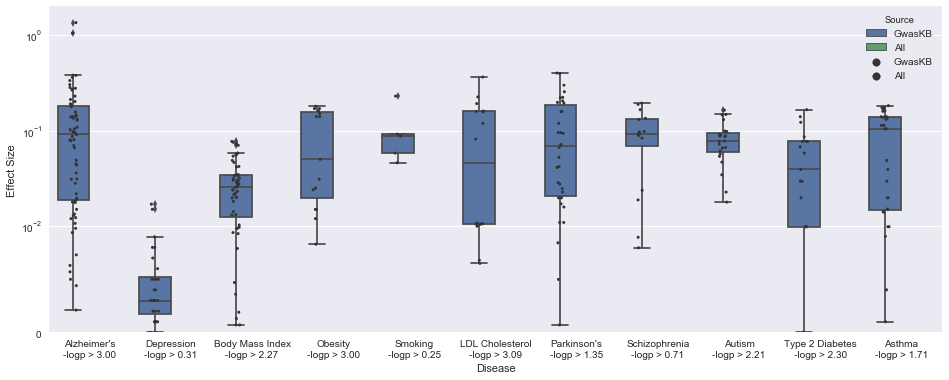

In [136]:
plt.figure(figsize=(16,6))
ax = sbn.stripplot(data=df4, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3)
ax = sbn.boxplot(data=df4, x='Disease', y='Effect Size', hue='Source', ax=ax)
ax.set_ylim([0.,2])
ax.set_yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)
# plt.savefig('/Users/kuleshov/Desktop/tmp.pdf')

In [110]:
violin_diseases = ["Alzheimer's\n-logp > 3.00", "Body Mass Index\n-logp > 2.27", "Autism\n-logp > 2.21", "Type 2 Diabetes\n-logp > 2.30", "Asthma\n-logp > 1.71"]

In [24]:
# this prints just the violin plots
import seaborn as sbn
import matplotlib
from matplotlib import rc
rc('text', usetex=False)

# sbn.set_context("paper", rc={"axes.titlesize":16,"axes.labelsize":16}) 

plt.clf()
sbn.set(style='darkgrid')
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

# violin_diseases = ["Alzheimer's\n-logp > 3.00", "Body Mass Index\n-logp > 2.27", "Autism\n-logp > 2.21", "Type 2 Diabetes\n-logp > 2.30", "Asthma\n-logp > 1.71"]
# df4 = df4[df4.Disease.isin(violin_diseases)].sort_values(['Disease', 'Source'], ascending=[True, False])
# df_all = df_all[df_all.Disease.isin(violin_diseases)].sort_values(['Disease', 'Source'], ascending=[True, False])

df4 = df4.sort_values(['Disease', 'Source'], ascending=[True, False])
df_all = df_all.sort_values(['Disease', 'Source'], ascending=[True, False])

# betas
ax = sbn.stripplot(data=df4, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3, ax=ax1)
# ax = sbn.stripplot(data=df4, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, edgecolor='grey',size=3, ax=ax1)
ax = sbn.boxplot(data=df4, x='Disease', y='Effect Size', hue='Source', ax=ax1)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
ax = sbn.violinplot(data=df_all, x='Disease', y='Effect Size', hue='Source', bw=0.1, scale='width', scale_hue=True, ax=ax, cut=0)
ax.set_ylim([0.,2])
ax.set_yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)

handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2])


l = ax.get_xticklabels()
ax.set_xticklabels(l, fontsize=8)
l = ax.get_xlabel()
ax.set_xlabel(l, fontsize=12)
l = ax.get_ylabel()
ax.set_ylabel(l, fontsize=12)

# plt.tight_layout()
plt.title('Distribution of Effect Sizes in Newly-Found vs Random SNPs', fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('all.violin.pdf')

And this just prints the bottom part

In [25]:
import seaborn as sbn

plt.clf()
sbn.set(style='darkgrid')
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
fig = plt.figure(figsize=(12,3))

# bottom part
diseasen = [1,7,10]
# plt.style.use('default')
for i, k in enumerate(diseasen):
    plt.subplot2grid((1, 3), (0, i))
    if k in betainds:
        plt.hist(np.absolute(allavgsamplebetas[k]), label="Random Sets Of SNPs", bins=50, edgecolor=None, linewidth=0.)
        plt.axvline(np.absolute(allavgbetas[k]), color='r', label='GwasKB SNPs', linewidth=2)
    else:
        plt.hist(np.absolute(np.log10(allavgsamplebetas[k])), label="Random Sets Of SNPs", bins=50, edgecolor=None, linewidth=0.)
        plt.axvline(np.absolute(np.log10(allavgbetas[k])), color='r', label='GwasKB SNPs', linewidth=2)      
    plt.title(disease_names[k])
    plt.tick_params(axis='both', labelsize=3)
    if i==2: plt.legend(loc="upper right")
    if k in betainds:
        plt.xlabel("Average Effect Size (|Beta|)")
    else:
        plt.xlabel("Average Effect Size (|log OR|)")
    if i == 0: plt.ylabel("Number Of Random SNP Subsets", fontsize=8)

# plt.tight_layout()
plt.suptitle('Distribution of Effect Sizes in Newly-Found vs Random SNPs')
plt.tight_layout()
plt.subplots_adjust(top=0.75)
# plt.show()
plt.savefig('all.violin.bottom.pdf')

In [ ]:
import pandas as pd
from itertools import chain
df_odds = pd.DataFrame({
        'Effect Size' : np.log(np.concatenate([np.concatenate([diseasesnpbetas[i], subsamp_betas[i]]) for i in oddsinds])),
        'Disease' : list(chain.from_iterable([[disease_names[i]] * (len(diseasesnpbetas[i]) + len(subsamp_betas[i])) for i in oddsinds])),
        'Source' : list(chain.from_iterable([['GwasKB'] * len(diseasesnpbetas[i]) + ['All'] * len(subsamp_betas[i]) for i in oddsinds])),
    })
df_beta = pd.DataFrame({
        'Effect Size' : (np.concatenate([np.concatenate([diseasesnpbetas[i], subsamp_betas[i]]) for i in betainds])),
        'Disease' : list(chain.from_iterable([[disease_names[i]] * (len(diseasesnpbetas[i]) + len(subsamp_betas[i])) for i in betainds])),
        'Source' : list(chain.from_iterable([['GwasKB'] * len(diseasesnpbetas[i]) + ['All'] * len(subsamp_betas[i]) for i in betainds])),
    })
df_all = pd.concat([df_beta, df_odds], ignore_index=True)

df2 = df_beta.loc[df_beta['Source'] == 'GwasKB']
for i in betainds:
    df2=df2.append({'Effect Size': -1.5, 'Disease': diseases[i], 'Source': 'All'}, ignore_index=True)
df2.tail()

df3 = df_odds.loc[df_odds['Source'] == 'GwasKB']
for i in oddsinds:
    df3=df3.append({'Effect Size': -1.5, 'Disease': diseases[i], 'Source': 'All'}, ignore_index=True)
df3.tail()

df4 = pd.concat([df3, df2], ignore_index=True)
df4.tail()

In [ ]:
import seaborn as sbn
plt.clf()
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

# betas
ax = sbn.stripplot(data=df2, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3, ax=ax1)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
# ax = sbn.boxplot(data=df_beta, x='disease', y='beta', hue='source', palette='muted', ax=ax)
ax = sbn.violinplot(data=df_beta, x='Disease', y='Effect Size', hue='Source', bw=0.1, palette='muted', scale='width', scale_hue=True, ax=ax)
ax.set_ylim([-1,2])
# plt.yscale('symlog')
ax.set_yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)
# plt.locator_params(axis='y', numticks=100)
# plt.yticks([0., 1e-3, 1e-2, 1e-1, 1.])

# ors
ax = sbn.stripplot(data=df3, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3, ax=ax2)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
ax = sbn.violinplot(data=df_odds, x='Disease', y='Effect Size', hue='Source', bw=0.1, palette='muted', scale='width', scale_hue=True, ax=ax)
ax.set_ylim([-1,2])
ax.set_yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)

# plt.tight_layout()
plt.show()

In [ ]:
# beta plot only
import seaborn as sbn
plt.clf()
ax = sbn.stripplot(data=df2, x='Disease', y='Effect Size', hue='Source', split=True, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
# ax = sbn.boxplot(data=df_beta, x='disease', y='beta', hue='source', palette='muted', ax=ax)
ax = sbn.violinplot(data=df_beta, x='Disease', y='Effect Size', hue='Source', bw=0.1, palette='muted', scale='width', scale_hue=True, ax=ax)
plt.ylim([-1,2])
# plt.yscale('symlog')
plt.yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)
# plt.locator_params(axis='y', numticks=100)
# plt.yticks([0., 1e-3, 1e-2, 1e-1, 1.])
plt.show()

In [16]:
from itertools import chain
data = list(chain.from_iterable([([diseasesnpbetas[i], subsamp_betas[i]]) for i in betainds]))
data2 = list(chain.from_iterable([([diseasesnpbetas[i], [], []]) for i in betainds]))
posn = list(chain.from_iterable([(3*i+0, 3*i+1) for i in range(len(betainds))]))

In [23]:
import seaborn as sbn
plt.clf()
plt.violinplot(data, posn , points=40, widths=1.,
                      showmeans=True, showextrema=True,
                      bw_method=0.1)
sbn.stripplot(data=data2, jitter=0.1, palette=sbn.color_palette(['#333333']), edgecolor='grey',size=3)
# plt.ylim([-0.2,1.])
plt.yticks([0., 1e-3, 1e-2, 1e-1, 1.])
plt.yscale('symlog', subsy=[0, 1, 2, 3, 4, 5], basey=10, linthreshy=1e-2)
plt.show()

In [26]:
[len(d) for d in data2]

[80, 0, 0, 36, 0, 0, 57, 0, 0, 29, 0, 0, 16, 0, 0, 16, 0, 0]